# 3. Multi-class Vnet on BV

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from dataset import *
from vnet import *
from training import *
from niiutility import show_image, show_batch_image

%matplotlib inline
%load_ext autoreload
%autoreload 2

## 3.1 Setup Torch Global Variable, load memory map 

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader, sampler, SubsetRandomSampler
from torchvision import transforms, utils

import torch.nn.functional as F  # useful stateless functions
import torchvision.transforms as T

#------------------------------- GLOBAL VARIABLES -------------------------------------#

USE_GPU = True
BATCH_SIZE = 8
NUM_WORKERS = 6
NUM_TRAIN = 80
LEARNING_RATE = 1e-2

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
    print('using GPU for training')
else:
    device = torch.device('cpu')

using GPU for training


In [3]:
#-------------------------LOAD THE DATA SET-------------------------------------------#

data_index = np.arange(107)
data_index = np.delete(data_index, 46)
dataset_trans = niiDataset(data_index, 
                         transform=transforms.Compose([
                             downSample(4),
                             RandomFilp(0.5),
                             RandomAffine(15, 10)
                         ])
                     )

#-------------------------CREATE DATA LOADER FOR TRAIN AND VAL------------------------#

data_size = len(dataset_trans)
train_loader = DataLoader(dataset_trans, batch_size=BATCH_SIZE, \
                    sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)),\
                    num_workers=NUM_WORKERS)
validation_loader = DataLoader(dataset_trans, batch_size=BATCH_SIZE,
                    sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN,data_size)),\
                    num_workers=NUM_WORKERS)

* Print first 4 batch of data

0 torch.Size([8, 1, 48, 64, 64]) torch.Size([8, 3, 48, 64, 64])
1 torch.Size([8, 1, 48, 64, 64]) torch.Size([8, 3, 48, 64, 64])
2 torch.Size([8, 1, 48, 64, 64]) torch.Size([8, 3, 48, 64, 64])
3 torch.Size([8, 1, 48, 64, 64]) torch.Size([8, 3, 48, 64, 64])


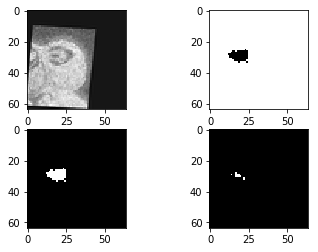

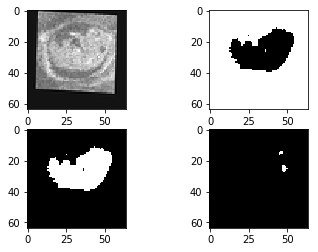

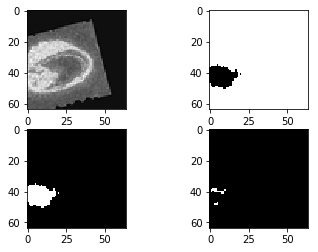

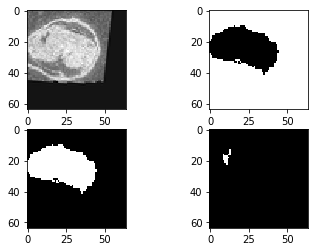

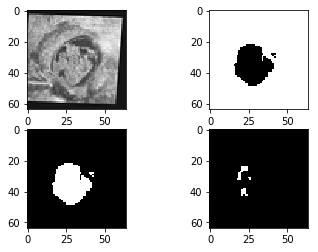

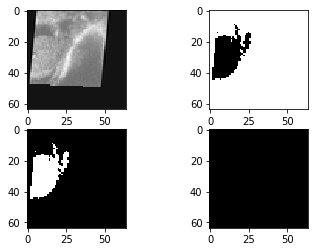

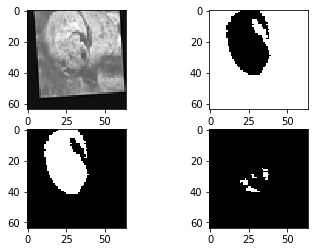

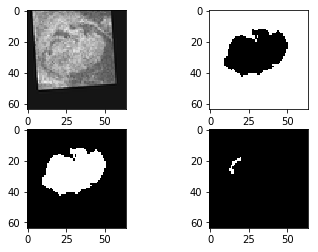

In [4]:
for i_batch, sample_batched in enumerate(train_loader):
    print(i_batch, sample_batched['image'].size(), \
          sample_batched['label'].size())
    # observe 4th batch and stop.
    if i_batch == 3:
        show_batch_image(sample_batched['image'],sample_batched['label'],BATCH_SIZE, level=4)
        break

In [5]:
from vnet import VNet

#-------------------------NEW MODEL INIT WEIGHT--------------------------------------#

model = VNet(classnum=3, slim=False)
model.apply(weights_init)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [6]:
train(model, train_loader, validation_loader, optimizer,\
      device=device, dtype=dtype, epochs=500)

Epoch 0 finished ! Training Loss: 0.18529217110739815
     validation loss = 0.3570
Epoch 1 finished ! Training Loss: 0.0994991660118103
     validation loss = 0.0926
Change Currculum! Reset LR Counter!
Epoch 2 finished ! Training Loss: 0.47186124987072414
     validation loss = 0.3427
Epoch 3 finished ! Training Loss: 0.4643104076385498
     validation loss = 0.3391
Epoch 4 finished ! Training Loss: 0.46658651696311104
     validation loss = 0.3536
Epoch 5 finished ! Training Loss: 0.45928308698866105
     validation loss = 0.3370
Epoch 6 finished ! Training Loss: 0.4556521707110935
     validation loss = 0.3400
Epoch 7 finished ! Training Loss: 0.45401978492736816
     validation loss = 0.3555
Epoch 8 finished ! Training Loss: 0.4531724850336711
     validation loss = 0.3410
Epoch 9 finished ! Training Loss: 0.4421444402800666
     validation loss = 0.3478
Epoch 10 finished ! Training Loss: 0.43800942103068036
     validation loss = 0.3349
Epoch 11 finished ! Training Loss: 0.4273487

     validation loss = 0.1175
Epoch 97 finished ! Training Loss: 0.158068405257331
     validation loss = 0.1343
Epoch 98 finished ! Training Loss: 0.16014900472429064
     validation loss = 0.1126
Epoch 99 finished ! Training Loss: 0.15457259946399265
     validation loss = 0.1183
Epoch 100 finished ! Training Loss: 0.144851201110416
     validation loss = 0.1486
Epoch 101 finished ! Training Loss: 0.1562881800863478
     validation loss = 0.1241
Epoch 102 finished ! Training Loss: 0.1513780819045173
     validation loss = 0.1147
Epoch 103 finished ! Training Loss: 0.15223396486706203
     validation loss = 0.1156
Epoch 104 finished ! Training Loss: 0.15000496970282662
     validation loss = 0.1291
Epoch 105 finished ! Training Loss: 0.1439637541770935
     validation loss = 0.1128
Epoch 106 finished ! Training Loss: 0.1408201257387797
     validation loss = 0.1316
Epoch 107 finished ! Training Loss: 0.15270845095316568
     validation loss = 0.1051
Epoch 108 finished ! Training Loss:

KeyboardInterrupt: 

In [7]:
#-------------------------SAVE THE MODEL STATE DICT----------------------------------#
PATH = 'Vet_currculum_326.pth'
torch.save(model.state_dict(), PATH)

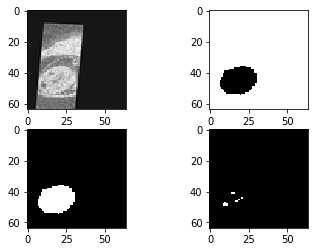

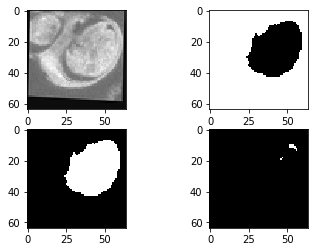

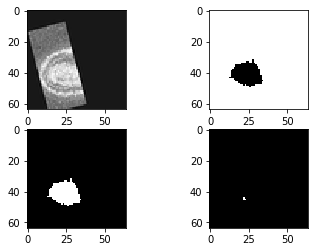

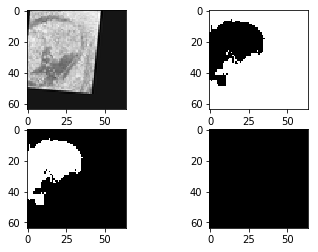

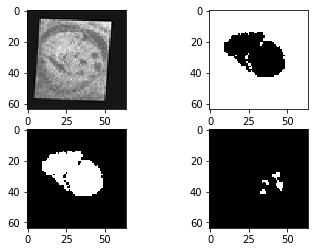

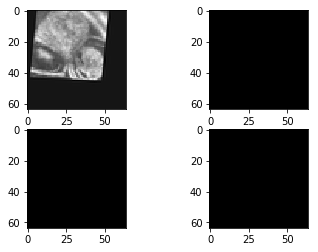

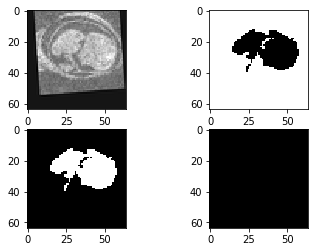

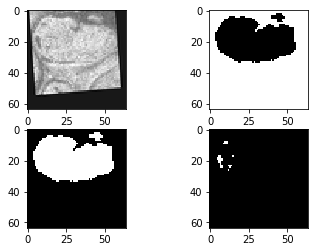

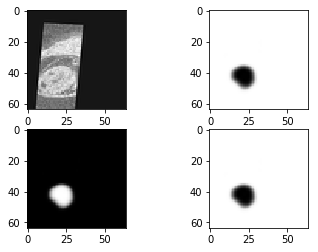

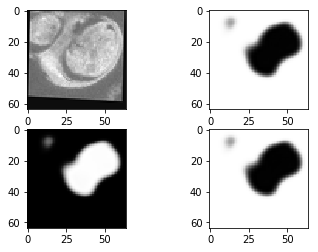

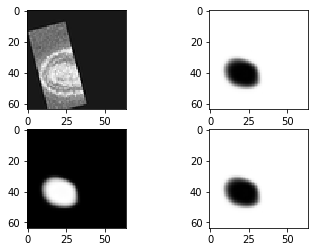

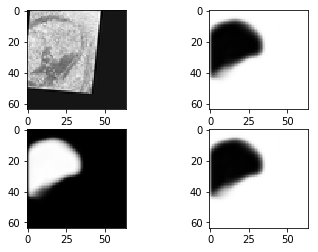

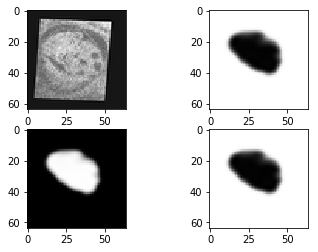

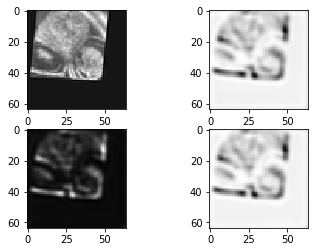

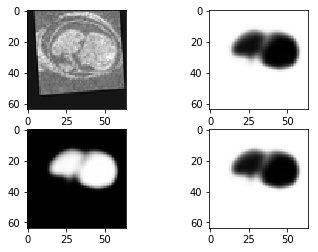

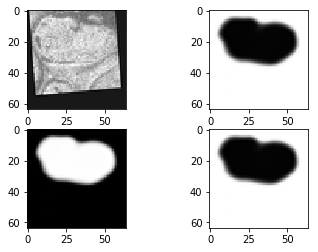

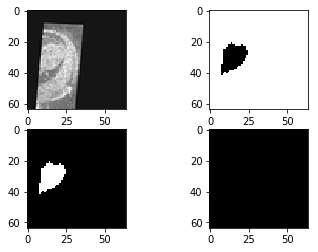

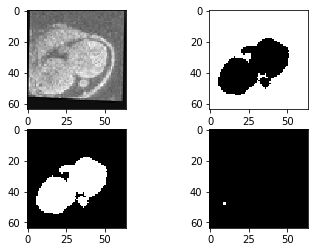

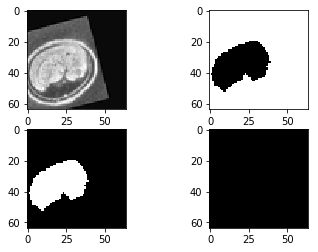

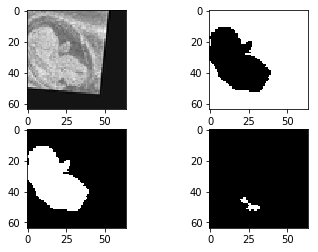

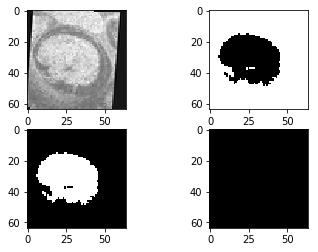

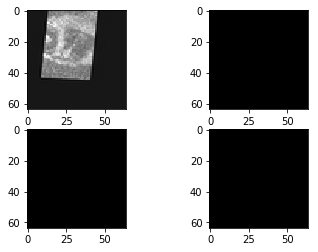

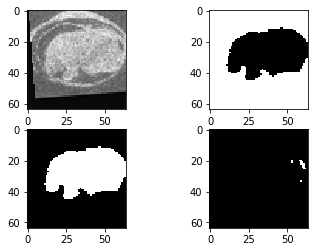

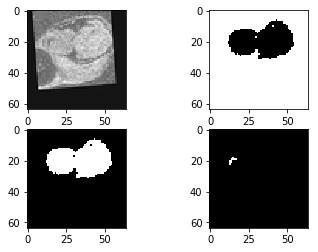

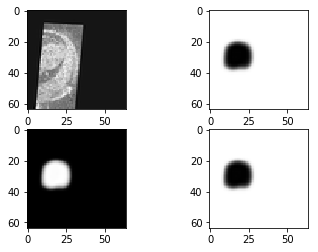

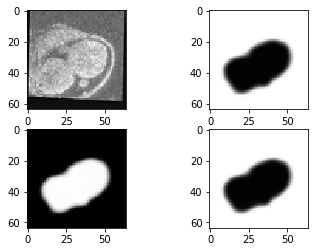

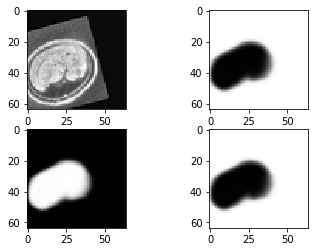

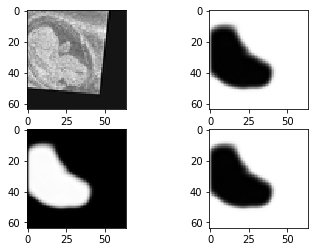

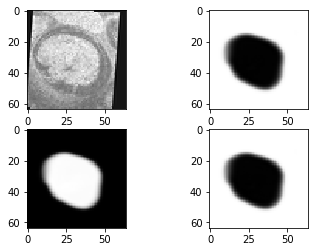

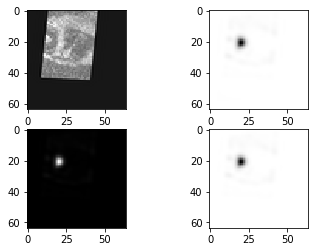

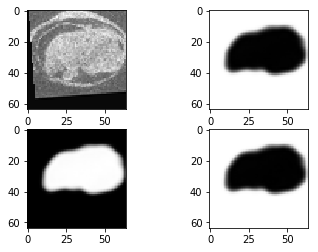

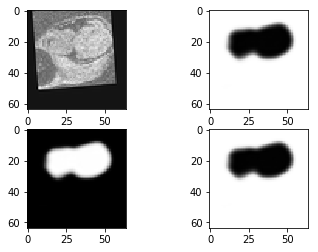

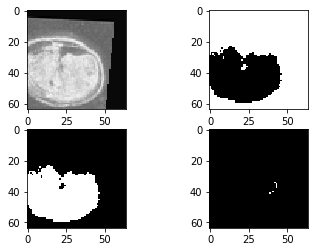

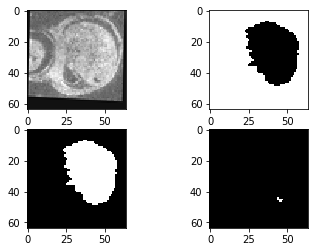

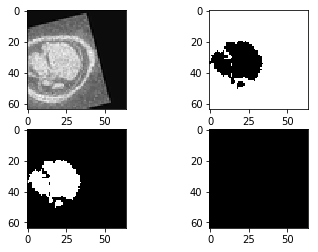

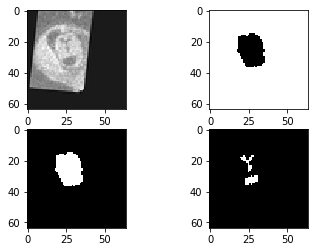

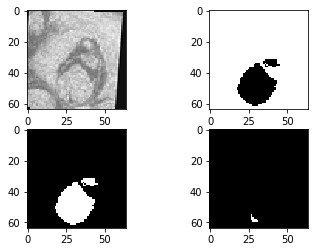

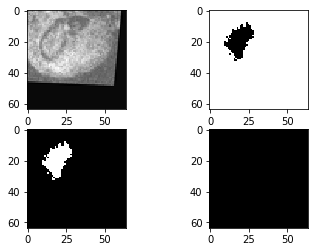

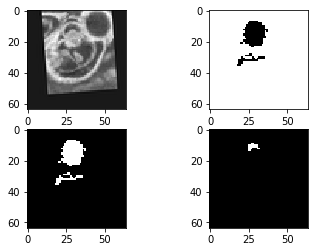

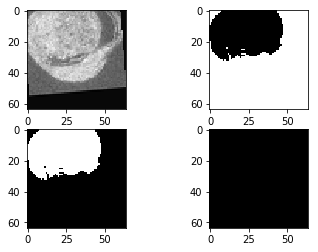

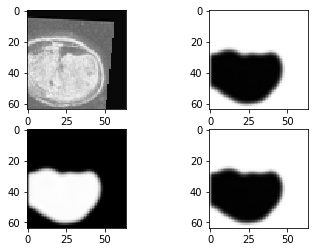

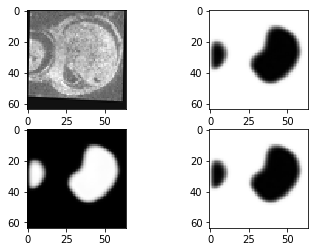

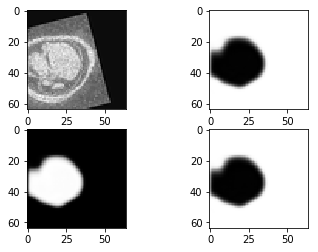

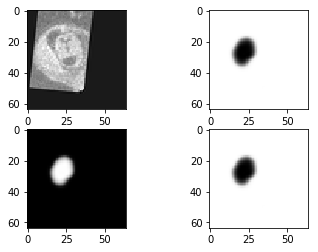

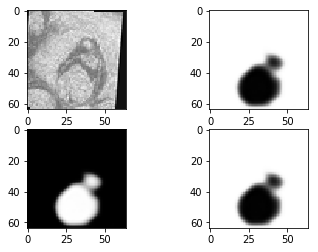

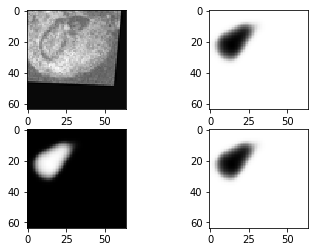

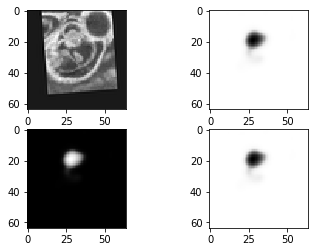

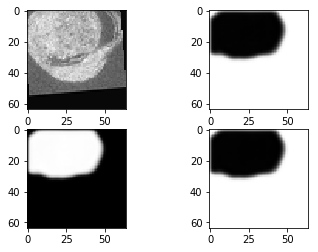

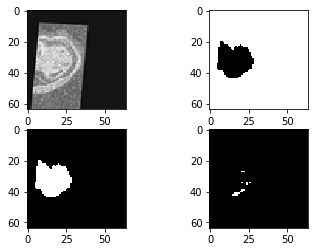

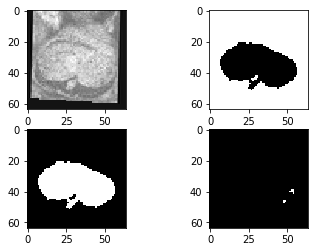

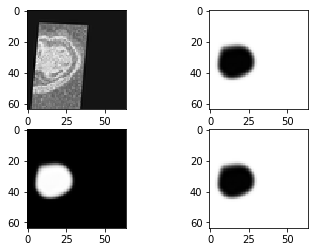

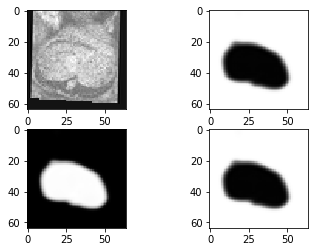

     validation loss = 0.0000


0.0

In [10]:
from training import check_img

check_img(model, validation_loader, device, dtype)